# Kaggle Playground S5E8 — Bank Term Deposit Subscription (Binary Classification)

This notebook builds strong baselines (Logistic Regression, XGBoost, LightGBM, CatBoost) with:
- Careful preprocessing (numeric + categorical)
- Stratified 5-Fold CV using ROC AUC
- Leakage guard (e.g., `duration`)
- Simple ensembling
- Ready-to-submit CSV

> Put `train.csv`, `test.csv`, and `sample_submission.csv` in the working directory.

In [1]:
import os, sys, gc, math, warnings, re
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, RocCurveDisplay, PrecisionRecallDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer

# Gradient Boosting models
try:
    from xgboost import XGBClassifier
except Exception as e:
    XGBClassifier = None
    print("XGBoost not available:", e)

try:
    from lightgbm import LGBMClassifier
except Exception as e:
    LGBMClassifier = None
    print("LightGBM not available:", e)

try:
    from catboost import CatBoostClassifier
except Exception as e:
    CatBoostClassifier = None
    print("CatBoost not available:", e)

RANDOM_STATE = 42
N_SPLITS = 5


In [2]:

# === Load data ===
train = pd.read_csv('train.csv')
test  = pd.read_csv('test.csv')
sub   = pd.read_csv('sample_submission.csv')

print(train.shape, test.shape, sub.shape)
display(train.head())
display(train.info())


(750000, 18) (250000, 17) (250000, 2)


,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,0,42,technician,married,secondary,no,7,no,no,cellular,25,aug,117,3,-1,0,unknown,0
1,1,38,blue-collar,married,secondary,no,514,no,no,unknown,18,jun,185,1,-1,0,unknown,0
2,2,36,blue-collar,married,secondary,no,602,yes,no,unknown,14,may,111,2,-1,0,unknown,0
3,3,27,student,single,secondary,no,34,yes,no,unknown,28,may,10,2,-1,0,unknown,0
4,4,26,technician,married,secondary,no,889,yes,no,cellular,3,feb,902,1,-1,0,unknown,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 18 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   id         750000 non-null  int64 
 1   age        750000 non-null  int64 
 2   job        750000 non-null  object
 3   marital    750000 non-null  object
 4   education  750000 non-null  object
 5   default    750000 non-null  object
 6   balance    750000 non-null  int64 
 7   housing    750000 non-null  object
 8   loan       750000 non-null  object
 9   contact    750000 non-null  object
 10  day        750000 non-null  int64 
 11  month      750000 non-null  object
 12  duration   750000 non-null  int64 
 13  campaign   750000 non-null  int64 
 14  pdays      750000 non-null  int64 
 15  previous   750000 non-null  int64 
 16  poutcome   750000 non-null  object
 17  y          750000 non-null  int64 
dtypes: int64(9), object(9)
memory usage: 103.0+ MB


None

## Quick EDA

y
0    0.879349
1    0.120651
Name: proportion, dtype: float64
Numeric columns: 8
Categorical columns: 9


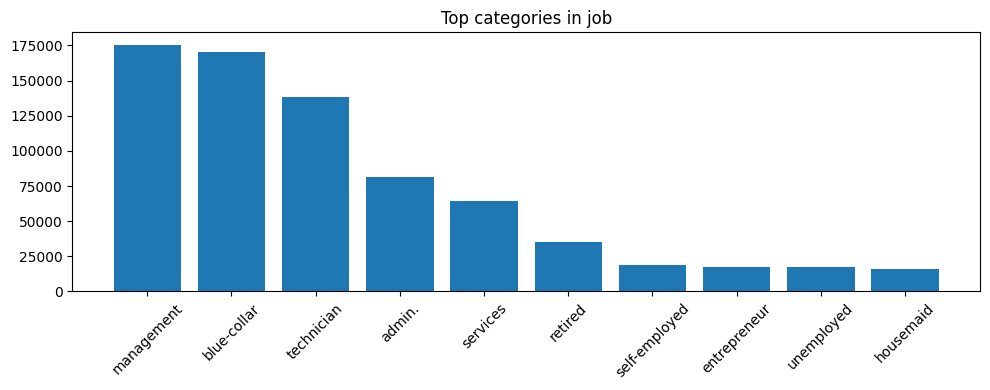

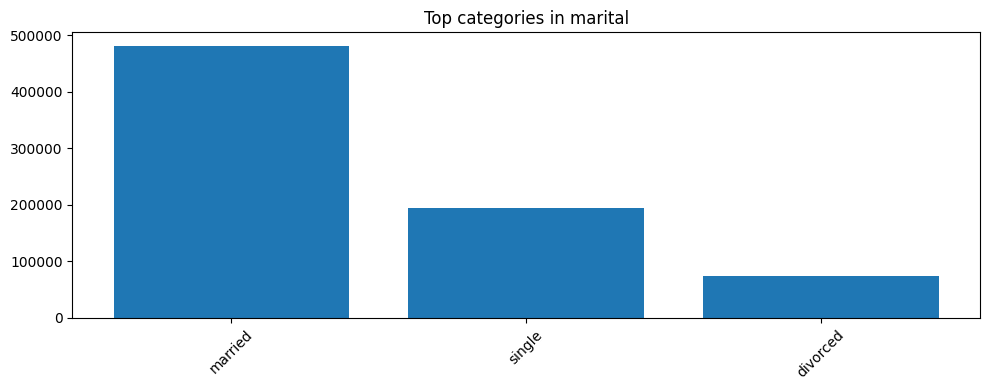

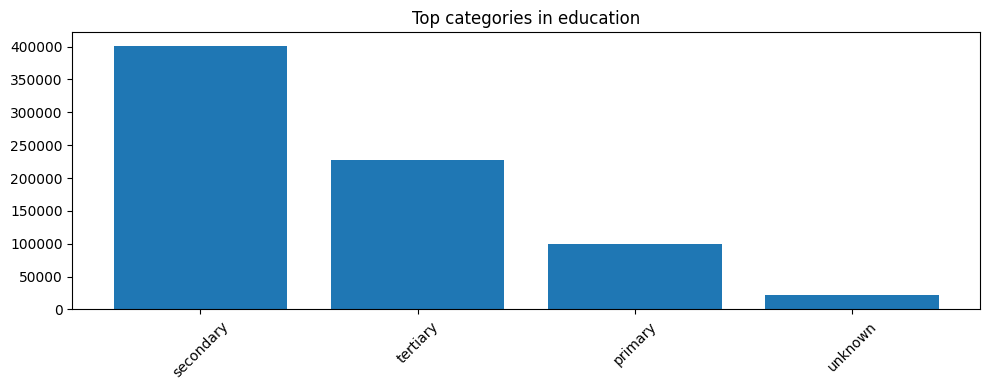

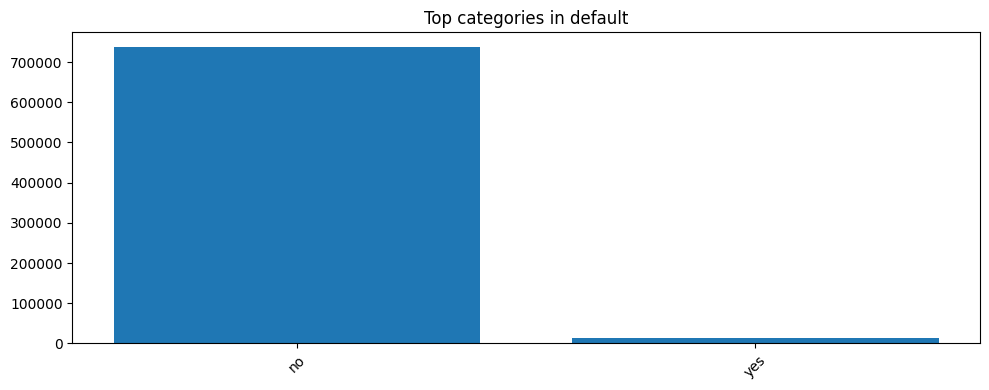

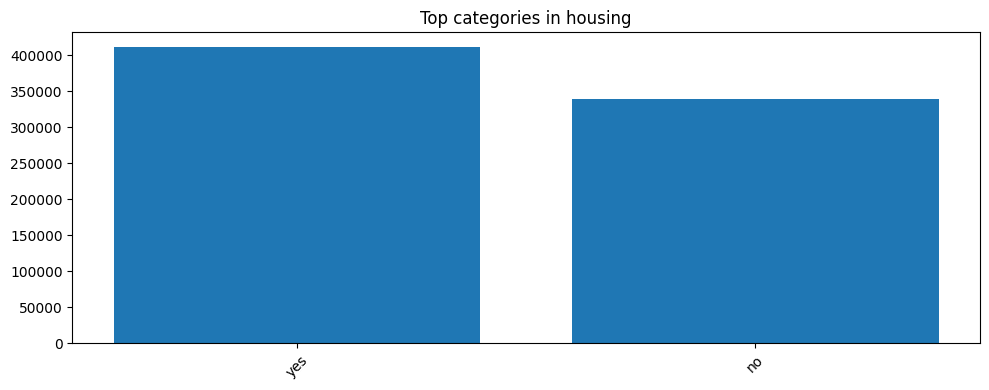

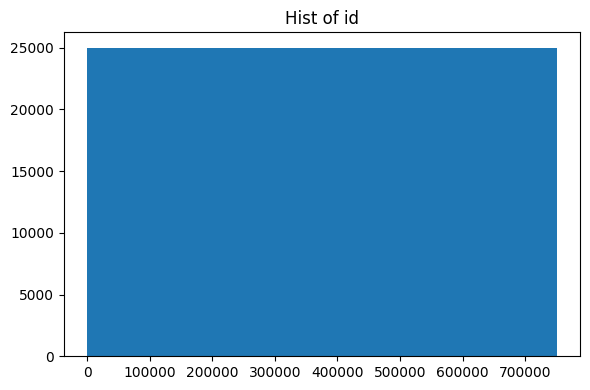

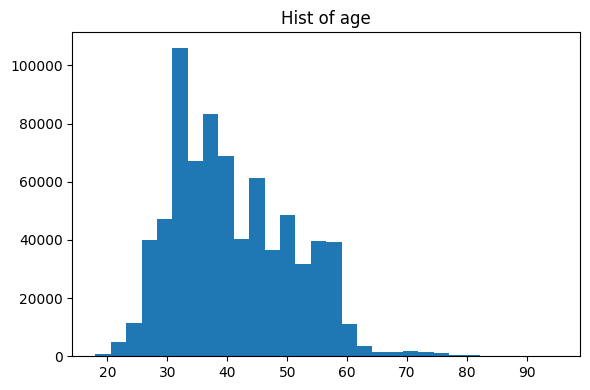

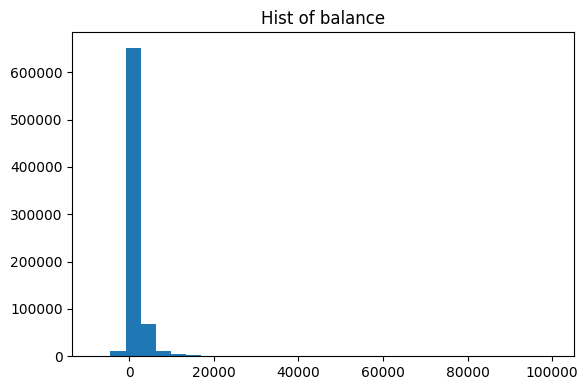

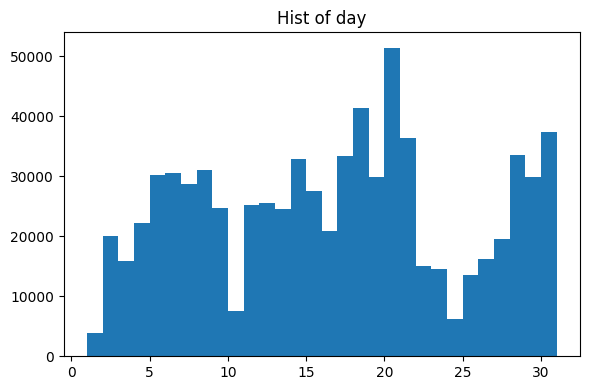

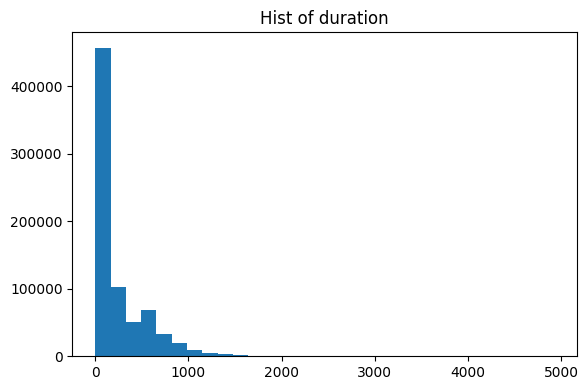

In [3]:

target_col = 'y'  # adjust if different in this competition
print(train[target_col].value_counts(normalize=True))

# Numeric vs categorical split (initial)
num_cols = train.drop(columns=[target_col]).select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in train.drop(columns=[target_col]).columns if c not in num_cols]
print("Numeric columns:", len(num_cols))
print("Categorical columns:", len(cat_cols))

# Plot a few categorical distributions (top 10 categories only)
for col in cat_cols[:5]:
    vc = train[col].value_counts().head(10)
    plt.figure(figsize=(10,4))
    plt.bar(vc.index.astype(str), vc.values)
    plt.title(f"Top categories in {col}")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Simple numeric histograms
for col in num_cols[:5]:
    plt.figure(figsize=(6,4))
    plt.hist(train[col].dropna(), bins=30)
    plt.title(f"Hist of {col}")
    plt.tight_layout()
    plt.show()



## Leakage Guard & Basic Feature Fixes
- Remove `duration` if present (classic leakage in bank marketing datasets).
- Convert `month` to an ordered integer if present.
- Handle `pdays == -1` as "Not contacted" (optional).


In [4]:

X_full = train.drop(columns=[target_col]).copy()
y = train[target_col].copy()
X_test = test.copy()

# 1) Drop duration if present
leak_cols = [c for c in X_full.columns if c.lower()=='duration']
if leak_cols:
    print("Dropping potential leakage:", leak_cols)
    X_full = X_full.drop(columns=leak_cols)
    X_test = X_test.drop(columns=leak_cols)

# 2) Month -> ordered
month_map = {'jan':1,'feb':2,'mar':3,'apr':4,'may':5,'jun':6,'jul':7,'aug':8,'sep':9,'oct':10,'nov':11,'dec':12}
for df in [X_full, X_test]:
    if 'month' in df.columns and df['month'].dtype == object:
        df['month_num'] = df['month'].map(month_map).fillna(0).astype(int)

# 3) pdays fix: create flag 'not_contacted' if pdays == -1
for df in [X_full, X_test]:
    if 'pdays' in df.columns:
        df['pdays_not_contacted'] = (df['pdays'] == -1).astype(int)

# Update column types
num_cols = X_full.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X_full.columns if c not in num_cols]

print("Numeric columns:", len(num_cols))
print("Categorical columns:", len(cat_cols))


Dropping potential leakage: ['duration']
Numeric columns: 9
Categorical columns: 9



## Preprocessing Pipelines
- Numeric: Median imputation + StandardScaler  
- Categorical: Most frequent imputation + OneHot (ignore unknown)


In [5]:

numeric_tf = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_tf = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=True))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_tf, num_cols),
        ('cat', categorical_tf, cat_cols)
    ]
)


## CV Utility

In [6]:

def cv_fit_predict_proba(pipe, X, y, X_test, n_splits=5, random_state=42, verbose_name="Model"):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    oof = np.zeros(len(X))
    test_pred = np.zeros(len(X_test))
    aucs = []

    for fold, (trn_idx, val_idx) in enumerate(skf.split(X, y), 1):
        X_tr, X_val = X.iloc[trn_idx], X.iloc[val_idx]
        y_tr, y_val = y.iloc[trn_idx], y.iloc[val_idx]

        pipe.fit(X_tr, y_tr)
        val_pred = pipe.predict_proba(X_val)[:, 1]
        oof[val_idx] = val_pred
        test_pred += pipe.predict_proba(X_test)[:, 1] / skf.get_n_splits()

        auc = roc_auc_score(y_val, val_pred)
        aucs.append(auc)
        print(f"[{verbose_name}] Fold {fold} AUC: {auc:.5f}")

    cv_auc = roc_auc_score(y, oof)
    print(f"[{verbose_name}] CV AUC: {cv_auc:.5f} | Folds: {[round(a,5) for a in aucs]}")
    return oof, test_pred, cv_auc



## Baseline Models
- Logistic Regression (class_weight='balanced')  
- XGBoost / LightGBM / CatBoost (if available)


In [7]:

models = {}
oofs = {}
tests = {}
cv_scores = {}

# Logistic Regression
pipe_lr = Pipeline(steps=[
    ('pre', preprocessor),
    ('clf', LogisticRegression(max_iter=2000, class_weight='balanced', n_jobs=-1))
])
oof_lr, test_lr, auc_lr = cv_fit_predict_proba(pipe_lr, X_full, y, X_test, n_splits=N_SPLITS, random_state=RANDOM_STATE, verbose_name="LogReg")
models['lr'] = pipe_lr; oofs['lr']=oof_lr; tests['lr']=test_lr; cv_scores['lr']=auc_lr

# XGBoost
if XGBClassifier is not None:
    xgb_params = dict(
        n_estimators=800,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        random_state=RANDOM_STATE,
        eval_metric='auc',
        tree_method='hist'
    )
    pipe_xgb = Pipeline(steps=[('pre', preprocessor), ('clf', XGBClassifier(**xgb_params))])
    oof_xgb, test_xgb, auc_xgb = cv_fit_predict_proba(pipe_xgb, X_full, y, X_test, n_splits=N_SPLITS, random_state=RANDOM_STATE, verbose_name="XGBoost")
    models['xgb']=pipe_xgb; oofs['xgb']=oof_xgb; tests['xgb']=test_xgb; cv_scores['xgb']=auc_xgb

# LightGBM
if LGBMClassifier is not None:
    lgbm_params = dict(
        n_estimators=1500,
        learning_rate=0.03,
        num_leaves=31,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=RANDOM_STATE,
        class_weight=None
    )
    pipe_lgb = Pipeline(steps=[('pre', preprocessor), ('clf', LGBMClassifier(**lgbm_params))])
    oof_lgb, test_lgb, auc_lgb = cv_fit_predict_proba(pipe_lgb, X_full, y, X_test, n_splits=N_SPLITS, random_state=RANDOM_STATE, verbose_name="LightGBM")
    models['lgb']=pipe_lgb; oofs['lgb']=oof_lgb; tests['lgb']=test_lgb; cv_scores['lgb']=auc_lgb

# CatBoost
if CatBoostClassifier is not None:
    cat_params = dict(
        iterations=1000,
        learning_rate=0.03,
        depth=6,
        random_seed=RANDOM_STATE,
        loss_function='Logloss',
        eval_metric='AUC',
        verbose=False
    )
    pipe_cat = Pipeline(steps=[('pre', preprocessor), ('clf', CatBoostClassifier(**cat_params))])
    oof_cat, test_cat, auc_cat = cv_fit_predict_proba(pipe_cat, X_full, y, X_test, n_splits=N_SPLITS, random_state=RANDOM_STATE, verbose_name="CatBoost")
    models['cat']=pipe_cat; oofs['cat']=oof_cat; tests['cat']=test_cat; cv_scores['cat']=auc_cat

print("CV scores:", cv_scores)


[LogReg] Fold 1 AUC: 0.79012
[LogReg] Fold 2 AUC: 0.78468
[LogReg] Fold 3 AUC: 0.78889
[LogReg] Fold 4 AUC: 0.78491
[LogReg] Fold 5 AUC: 0.78470
[LogReg] CV AUC: 0.78665 | Folds: [0.79012, 0.78468, 0.78889, 0.78491, 0.7847]
[XGBoost] Fold 1 AUC: 0.85772
[XGBoost] Fold 2 AUC: 0.85384
[XGBoost] Fold 3 AUC: 0.85437
[XGBoost] Fold 4 AUC: 0.85462
[XGBoost] Fold 5 AUC: 0.85326
[XGBoost] CV AUC: 0.85476 | Folds: [0.85772, 0.85384, 0.85437, 0.85462, 0.85326]
[LightGBM] [Info] Number of positive: 72391, number of negative: 527609
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027997 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1063
[LightGBM] [Info] Number of data points in the train set: 600000, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.120652 -> initscore=-1.986273
[LightGBM] [Info] Start training from s

## Ensembling (Blending)
Weighted average using CV AUC as weights.

In [8]:

available = {k:v for k,v in tests.items() if k in cv_scores and np.isfinite(cv_scores[k])}
if len(available) == 0:
    raise RuntimeError("No model predictions available. Check installations.")

weights = {k: cv_scores[k] for k in available.keys()}
w_sum = sum(weights.values())
weights = {k: v / w_sum for k, v in weights.items()}

print("Blend weights:", weights)

blend_test = np.zeros(len(X_test))
oof_blend = np.zeros(len(X_full))
for k in available.keys():
    blend_test += weights[k] * tests[k]
    oof_blend  += weights[k] * oofs[k]

print("OOF Blend AUC:", roc_auc_score(y, oof_blend))


Blend weights: {'lr': 0.23534438925976486, 'xgb': 0.25572000620717217, 'lgb': 0.25542705740356575, 'cat': 0.2535085471294972}
OOF Blend AUC: 0.8380261547088682


## Save Submission

In [9]:

sub_out = sub.copy()
pred_col = sub_out.columns[-1]
sub_out[pred_col] = blend_test
sub_path = "submission.csv"
sub_out.to_csv(sub_path, index=False)
print("Saved:", sub_path)
sub_out.head()


Saved: submission.csv


,id,y
0,750000,0.073938
1,750001,0.178282
2,750002,0.108865
3,750003,0.019910
4,750004,0.287407



## (Optional) Feature Importance
Re-fit one boosting model on full data to display feature importance after preprocessing.


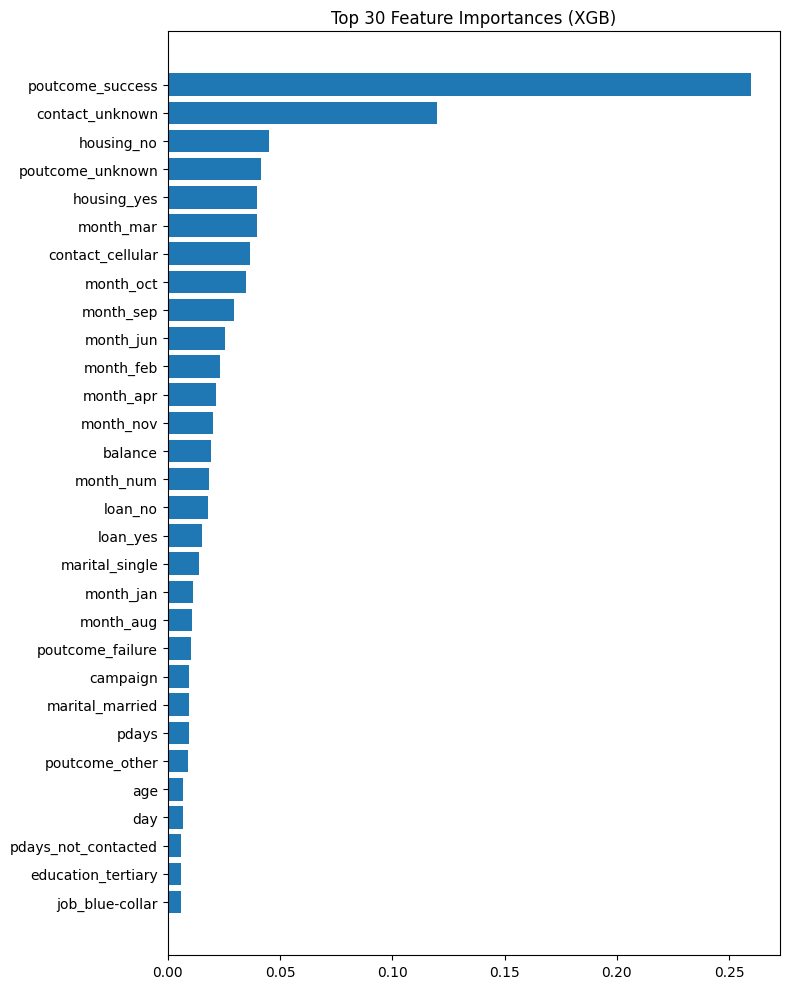

In [10]:

if 'xgb' in models:
    pipe_final = Pipeline(steps=[
        ('pre', preprocessor),
        ('clf', XGBClassifier(n_estimators=1000, learning_rate=0.03, max_depth=6,
                              subsample=0.8, colsample_bytree=0.8, random_state=RANDOM_STATE,
                              eval_metric='auc', tree_method='hist'))
    ])
    pipe_final.fit(X_full, y)

    pre = pipe_final.named_steps['pre']
    oh = pre.named_transformers_['cat'].named_steps['onehot']
    num_features = pre.named_transformers_['num'].named_steps['imputer'].get_feature_names_out(num_cols)
    cat_features = oh.get_feature_names_out(cat_cols)
    feature_names = np.concatenate([num_features, cat_features])

    booster = pipe_final.named_steps['clf']
    try:
        importances = booster.feature_importances_
        idx = np.argsort(importances)[::-1][:30]
        plt.figure(figsize=(8,10))
        plt.barh(range(len(idx)), importances[idx][::-1])
        plt.yticks(range(len(idx)), [feature_names[i] for i in idx][::-1])
        plt.title("Top 30 Feature Importances (XGB)")
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print("Could not plot importances:", e)
else:
    print("XGB model not available, skipping feature importance.")
